# 09 - Cumprimento Parcial e LATE

## Mergulhando em um Mundo Heterogêneo

Anteriormente, vimos Variáveis Instrumentais (IV) por meio de uma lente mais tradicional. A IV era considerada uma espécie de experimento natural que poderíamos aproveitar. Em contraste, a prática moderna de IV obtém muitos insights das ciências médicas. Ela divide o mundo em 4 tipos de sujeitos, dependendo de como eles respondem à variável instrumental.

1. Cumpridores
2. Nunca Aceitantes
3. Sempre Aceitantes
4. Desafiadores

Esse nome vem da ciência farmacêutica. Imagine que você está conduzindo um experimento para testar o efeito de um novo medicamento em alguma doença. Cada sujeito é designado para um tratamento: um medicamento ou um placebo. Os cumpridores são os sujeitos que seguem o que lhes foi atribuído. Se recebem o placebo, o tomam; se recebem o medicamento, também o tomam. Os nunca aceitantes são aqueles sujeitos que se recusam a tomar o medicamento. Mesmo que sejam designados para o novo medicamento, eles não o tomarão. Por outro lado, os sempre aceitantes são aqueles que de alguma forma conseguem obter o novo medicamento mesmo que tenham sido designados para o placebo. Por fim, os desafiadores são aqueles que seguem o tratamento se designados para o grupo de controle e seguem o controle se designados para o tratamento. Você pode pensar neles como aquela criança irritante que faz o oposto do que lhe é dito. Na prática, eles não são tão comuns (os desafiadores, não as crianças), então frequentemente os ignoraremos.

![img](./data/img/late/defiers.png)

A IV moderna trata o instrumento como um desenho quase experimental onde a conformidade não é perfeita. Ao fazer isso, ela se distingue internamente de efeitos causais externamente válidos. Apenas como um lembrete, um efeito internamente válido é aquele que somos capazes de identificar. Ele é válido naquele cenário específico, com aqueles dados específicos. Em IV, seria o efeito do tratamento naqueles em que o instrumento altera o tratamento. A validade externa, por outro lado, estaria preocupada com o poder preditivo desse efeito causal. Ela perguntaria se poderíamos generalizar o efeito que encontramos nesta amostra para outras populações. Por exemplo, suponha que você conduziu um ensaio clínico randomizado em sua universidade para descobrir se as pessoas são generosas ou não quando incentivadas a doar. O experimento é bem projetado, mas você convida apenas estudantes de economia para participar. Então, você descobre que todos eles são egoístas. Esta é uma conclusão internamente válida. É válida para esses pontos de dados. Mas, a partir desse experimento, você pode inferir que a humanidade é egoísta? Isso é difícil de afirmar. Portanto, questionaríamos se o seu experimento tem validade externa para generalizar seus resultados. De qualquer forma, voltando ao IV.

Para tornar isso mais concreto, consideremos um caso em que você deseja aumentar o engajamento do usuário, medido por compras dentro do aplicativo. Uma maneira de fazer isso é pedir ao departamento de marketing que crie uma notificação que você possa usar para envolver seus usuários. Eles elaboram um design brilhante e interações de usuário muito sofisticadas. Com essa notificação, você prossegue para projetar um ensaio randomizado. Você seleciona aleatoriamente 10.000 clientes e, para cada um deles, atribui a notificação com 50% de probabilidade. No entanto, ao executar o teste, você percebe que alguns clientes designados para receber a notificação não a estão recebendo. Quando você fala com os engenheiros, eles dizem que isso provavelmente ocorre porque eles têm um telefone mais antigo que não suporta o tipo de notificação que a equipe de marketing projetou.

Inicialmente, você pode pensar que isso não é grande coisa. Em vez de usar o tratamento designado como sua variável de tratamento, você pode simplesmente usar o tratamento recebido, certo? Acontece que não é tão simples assim. Se você traçar o gráfico causal de toda essa situação, parecerá algo assim:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")

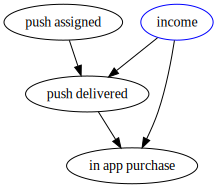

In [2]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

No gráfico causal, você tem a atribuição da notificação. Isso é aleatório por design, então nada o está causando. Em seguida, você tem um nó para se a notificação foi entregue. Nem todos que foram designados para receber a notificação a receberam, então há cumprimento parcial aqui. Mais especificamente, você tem alguns nunca aceitantes: aqueles que não recebem o tratamento, mesmo que designados para ele. Você também tem razões para suspeitar que esse cumprimento parcial não é simplesmente por acaso. Como as pessoas com telefones mais antigos são aquelas que não recebem a notificação, você pode argumentar que a renda também está causando a entrega da notificação. Quanto mais rica a pessoa, mais provável é que ela tenha um telefone melhor, o que, por sua vez, torna mais provável que ela receba a notificação. Finalmente, você tem a variável de resultado, a compra dentro do aplicativo. Tenha em mente que não conhecemos a renda, então não podemos controlá-la. Com isso em mente, vamos examinar o que aconteceria se simplesmente usássemos a notificação atribuída como a variável de tratamento e se, em vez disso, usássemos a notificação entregue como o tratamento.

No primeiro caso, estimaríamos o efeito causal pela seguinte diferença nas médias:

$
ATE = E[Y | pushAssigned=1] - E[Y | pushAssigned=0]
$

Como estamos muito cientes agora, esta é apenas uma estimativa não viesada para $E[Y_1] - E[Y_0]$ se o viés $E[Y_0|pushAssigned=0] - E[Y_0|pushAssigned=1]$ for zero. Como `pushAssigned` é aleatório, sabemos que o viés é zero. Isso resolve então? Não exatamente. Veja, se fizermos isso, estaríamos respondendo a uma pergunta diferente daquela que pretendíamos. Estaríamos encontrando o **efeito causal da atribuição de tratamento**, não do tratamento em si. Mas eles são diferentes ou podemos extrapolar o efeito causal da atribuição de tratamento para o Efeito Médio de Tratamento (ATE, do inglês)? Em outras palavras, o efeito causal da atribuição de tratamento é uma estimativa não viesada do ATE?

Acontece que não é. Devido ao cumprimento parcial, o resultado daqueles designados para o tratamento será direcionado na direção do resultado daqueles designados para o controle. O cumprimento parcial inverte o tratamento inadvertidamente, tornando o tratamento e o controle mais semelhantes no resultado. Não confunda isso com semelhança nas variáveis. Queremos que tratados e controle sejam semelhantes nas variáveis. Isso os tornará comparáveis. O que não queremos é que sejam semelhantes no resultado se houver de fato um efeito de tratamento.

Para entender isso, suponha primeiro que temos sempre aceitantes. Alguns deles serão designados para o grupo de controle por acaso. Mas aqueles que forem designados, mesmo assim, tomarão o tratamento. Isso os torna essencialmente um grupo tratado que está misturado com o controle. Como resultado dessa mistura, o efeito causal será mais difícil de encontrar quando houver cumprimento parcial.

![img](./data/img/late/always_takers.png)

Pelo mesmo raciocínio, nunca aceitantes farão com que aqueles designados para o tratamento se pareçam um pouco com os não tratados, pois eles não tomam o tratamento mesmo que designados para ele. Nesse sentido, **o efeito causal da atribuição de tratamento é enviesado em direção a zero** porque o cumprimento parcial reduz o impacto detectável. Outra maneira de ver isso é imaginar um caso extremo. Digamos que o cumprimento parcial seja realmente alto. A atribuição de tratamento não diz nada sobre o tratamento recebido. O tratamento recebido é puramente aleatório nesse caso. Na linguagem de IV, isso seria dizer que temos um 1º estágio muito fraco. Usando `Z` para denotar a atribuição de tratamento, teríamos que

$
E[Y|Z=1] - E[Y|Z=0] = 0
$

Não haveria mais uma ligação causal da atribuição de tratamento para o resultado. Z seria apenas uma variável aleatória sem sentido flutuando ali.

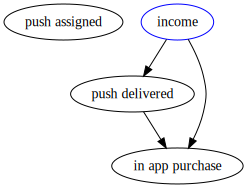

In [3]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

Certo, então descartamos o uso do efeito causal da atribuição como uma forma de estimar o efeito causal do tratamento. Então, que tal apenas usar o tratamento recebido?

$
\mathrm{ATE} = E[Y | \mathrm{push}=1] - E[Y | \mathrm{push}=0]
$

Mais uma vez, precisamos pensar se isso é enviesado ou não, ou se $E[Y_0|\mathrm{push}=0] = E[Y_0|\mathrm{push}=1]$. Apenas olhando para o gráfico causal acima, sabemos que não é o caso. Temos aquele confundidor não medido, a renda, rondando por aí, e certamente isso vai complicar as coisas. Como mencionamos anteriormente, sabemos que a falha na entrega da notificação, em nosso caso, é causada pelo fato de os clientes terem telefones mais antigos. O que significa que provavelmente temos $E[Y_0|\mathrm{push}=0] < E[Y_0|\mathrm{push}=1]$. Achamos que isso ocorre porque os clientes com menos dinheiro têm tanto telefones mais antigos, o que levará a $\mathrm{push}=0$, quanto um potencial de compra dentro do aplicativo $Y_0$ mais baixo.

Que pena! Não podemos usar nem a atribuição de tratamento nem o tratamento recebido para estimar nosso ATE. Mas felizmente, sabemos o que podemos usar: Variáveis Instrumentais. Aqui, a atribuição de tratamento é o instrumento perfeito para o tratamento. É tão bom quanto aleatório e só causa a compra dentro do aplicativo pela virtude do tratamento.

## Efeito Médio de Tratamento Local: LATE

O efeito médio de tratamento local explicita a população para a qual podemos estimar o efeito causal. Também é outra maneira de visualizar IV, que oferece outras intuições interessantes que podemos utilizar. Na IV moderna, vemos o instrumento como iniciando uma cadeia causal: Z causa T que causa Y. Nesse contexto, a restrição de exclusão significa que Z não causa Y, a menos por seu efeito em T. O primeiro estágio é agora visto como o efeito causal de Z sobre T. Também reescrevemos os resultados potenciais com uma notação de duplo índice, onde o primeiro índice denota o contrafactual para o instrumento e o segundo índice, para o tratamento.

$
\text{Potential Outcome}=\begin{cases}
Y_i(1, 1) \ \text{if } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{if } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{if } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{if } T_i=0, \ Z_i=0\\
\end{cases}
$

Em certo sentido, o tratamento se torna o resultado, pelo menos no primeiro estágio. Isso significa que também podemos escrevê-lo com a notação de resultados potenciais:

$
\text{Potential Treatment}=\begin{cases}
T_0 \ \text{if } Z_i=0 \\
T_1 \ \text{if } Z_i=1
\end{cases}
$

![img](./data/img/late/double_index.png)

As suposições da Variável Instrumental podem agora ser reescritas da seguinte forma:

1. $T_{0i}, T_{1i} \perp Z_i$ e $Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i$. Esta é a Assunção de Independência. Isso indica que o instrumento é tão bom quanto atribuído aleatoriamente. Em outras palavras, Z, o instrumento, não está correlacionado com os tratamentos potenciais, o que é o mesmo que dizer que pessoas em diferentes grupos de instrumentos são comparáveis.

2. $Y_i(1, 0)=Y_i(1, 1)=Y_{i1}$ e $Y_i(0, 0)=Y_i(0, 1)=Y_{i0}$. Esta é a restrição de exclusão. Isso indica que, se estou observando o resultado potencial para o tratado, é o mesmo para ambos os grupos de instrumentos. Em outras palavras, o instrumento não afeta o resultado potencial, o que é o mesmo que dizer que o instrumento só afeta o resultado por meio do tratamento.

3. $E[T_{1i}-T_{0i}] \neq 0$. Esta é a existência de um primeiro estágio. Isso indica que o resultado potencial do primeiro estágio, ou seja, o tratamento potencial, NÃO é o mesmo. Outra maneira de dizer isso é que o instrumento afeta o tratamento.

4. $T_{i1} > T_{i0}$. Esta é a suposição de monotonicidade. Isso indica que se todos tivessem o instrumento ativado, o nível de tratamento seria maior do que se todos tivessem o tratamento desativado.

Agora, vamos revisar o estimador de Wald para ganhar mais intuição sobre IV:

$
ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

Vamos pegar a primeira parte dela, $E[Y|Z=1]$. Usando a restrição de exclusão, podemos reescrever Y em termos de resultados potenciais da seguinte forma.

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]
$

Usando a independência, podemos retirar a condição em Z.

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]
$

Com um argumento semelhante, obtemos que

$
E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]
$

Agora podemos reescrever o numerador do estimador de Wald da seguinte forma

$
E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]
$

Usando a monotonicidade, sabemos que $T_{i1}-T_{i0}$ é 0 ou 1, então

$
E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})
$

Usando um argumento semelhante para lidar com o denominador, obtemos

$
E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})
$

Tudo isso nos permite olhar para o estimador de Wald da seguinte forma:

$
ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}>T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]
$

Isso é, o ATE estimado por IV é o ATE na subpopulação onde $T_{i1}>T_{i0}$. E se você pensar sobre o cumprimento, qual é essa população? Esta é a população em que aqueles que têm o instrumento ativado têm o nível de tratamento mais alto do que se tivessem o instrumento desativado. Em outras palavras, esta é a população de cumpridores. Apenas para lembrar,

1. Cumpridores significam que $T_{i1}>T_{i0}$
2. Nunca Aceitantes $T_{i1}=T_{i0}=0$
3. Sempre Aceitantes $T_{i1}=T_{i0}=1$

A conclusão disso é que IV não fornece informações sobre o efeito nos nunca aceitantes, sempre aceitantes ou desafiadores, porque o tratamento não é alterado para eles! **IV apenas encontra o efeito do tratamento para os cumpridores**.

## Efeito no Engajamento

Vamos ver como tudo isso se desenrola no estudo de caso em que tentamos estimar o efeito de uma notificação em compras dentro do aplicativo. O gráfico causal é o que descrevemos acima, então não vou repeti-lo aqui. Os dados que temos incluem tanto a atribuição de notificação, o instrumento randomizado, quanto a entrega da notificação, a variável de tratamento.

In [9]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


Primeiro, vamos executar OLS para ver o que ele nos daria.

In [10]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


OLS está indicando que o efeito do tratamento é de BRL 27,60, ou seja, a notificação aumenta a compra dentro do aplicativo em 27,6 reais. No entanto, temos motivos para acreditar que esta é uma estimativa enviesada. Sabemos que os telefones mais antigos estão tendo problemas para receber a notificação, então, provavelmente, os clientes mais ricos, com telefones mais novos, são os cumpridores. Como aqueles que recebem o tratamento também têm mais dinheiro, acreditamos que esse viés é positivo e o impacto real da notificação é menor. Em outras palavras, provavelmente temos $E[Y_0|T=0] < E[Y_0|T=1]$.

Agora, vamos tentar estimar esse efeito com Variáveis Instrumentais. Primeiro, vamos executar o primeiro estágio.

In [11]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0000,7.408e-11,0.0000,1.0000,-1.452e-10,1.452e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


Parece que temos um primeiro estágio forte. Aqueles que são designados para receber a notificação a recebem 71,8% das vezes. Isso significa que temos algo em torno de 28% de nunca aceitantes. Também temos fortes razões para acreditar que não há sempre aceitantes, uma vez que o parâmetro de interceptação é estimado como zero. Isso significa que ninguém recebe a notificação se não for designado para isso. Dado o design do nosso experimento, isso é esperado.

Agora, vamos executar a forma reduzida:

In [7]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


A forma reduzida mostra que o efeito causal da atribuição de tratamento é 2,36. Isso significa que designar alguém para receber a notificação aumenta a compra dentro do aplicativo em 2,36 reais.

Se dividirmos a forma reduzida pelo primeiro estágio, escalamos o efeito do instrumento pelas unidades do tratamento, obtemos $2,3636/0,7176=3,29$. Executando o 2SLS, obtemos essas mesmas estimativas, com o bônus de ter erros padrão corretos.

In [8]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


Isso mostra que o resultado com 2SLS é muito menor do que aquele que obtivemos com OLS: 3,29 contra 27,60. Isso faz sentido, uma vez que o efeito causal estimado com OLS está positivamente enviesado. Também precisamos lembrar sobre o LATE. 3,29 é o efeito causal médio nos cumpridores. Infelizmente, não podemos dizer nada sobre aqueles nunca aceitantes. Isso significa que estamos estimando o efeito no segmento mais rico da população que tem telefones mais novos.

## Conceitos-chave

Aqui, examinamos uma visão mais moderna de Variáveis Instrumentais. Vimos como o IV pode ser visto como uma cadeia causal onde o instrumento causa o tratamento que causa o resultado. Nessa visão, analisamos o cumprimento para entender o Efeito Médio de Tratamento (ATE) na estimativa de IV e descobrimos que era o LATE nos cumpridores.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e [abra uma issue](https://github.com/matheusfacure/python-causality-handbook/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma [estrela no GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).

---

***Nota de tradução**: O título original é "Non-compliance and LATE", onde numa uma tradução direta seria "Não conformidade e LATE". Preferi utilizar "Cumprimento Parcial" em vez de "Nâo conformidade" para manter o padrão adotado no livro "Avaliação de Impacto na
Prática, 2ºEd" produzido pelo Banco Mundial e disponibilizado gratuitamente [aqui](https://publications.iadb.org/publications/portuguese/document/Avalia%C3%A7%C3%A3o-de-impacto-na-pr%C3%A1tica-Segunda-edi%C3%A7%C3%A3o.pdf).*

<div align="center">
<a href="08-Instrumental-Variables.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="10-Matching.ipynb">Próximo --></a>  
</div>